## tjaファイルのパース
---

In [75]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from scipy import signal
from scipy.fftpack import fft
from librosa.filters import mel
from librosa.display import specshow
from librosa import stft
from librosa.effects import pitch_shift
import pickle
import sys
from numba import jit, prange
from sklearn.preprocessing import normalize

In [76]:
def import_tja(filename, diff=False):
    
    timestamp = []
    title = ''
    bpm = 100
    wav = ''
    now = 0  # for offset
    measure = [4,4]
    
    with open(filename, "rb") as f:

        while True:
        
            line = f.readline()
            
            try:
                line = line.decode('utf-8')
            except UnicodeDecodeError:
                line = line.decode('sjis')
            
            # findメソッドは引数に渡されたパターンんが最初に現れるインデックスを返す else: return -1
            if line.find('//') != -1:
                line = line[:line.find('//')]
            if line[0:5] == 'TITLE':
                title = line[6:-2]
            elif line[0:4] == 'BPM:':
                bpm = float(line[4:-2])
            elif line [0:6] == 'OFFSET':
                now = -float(line[7:-2])
            elif line == '#START\r\n':
                break
            
        sound = []
        while True:

            line = f.readline()
            
            try:
                line = line.decode('utf-8')
            except UnicodeDecodeError:
                line = line.decode('sjis')


            if line.find('//') != -1:
                line = line[:line.find('//')]

            if line[0] <= '9' and line[0] >= '0':
                if line.find(',') != -1:
                    sound += line[0:line.find(',')]
                    beat = len(sound)

                    for i in range(beat):
                        if diff:
                            if int(sound[i]) in (1,3,5,6,7):  # ドン
                                timestamp.append(
                                    [int(100*(now+i*60*measure[0]/bpm/beat))/100,1])  # 1 / beat秒のタイムスタンプと，トークン(1,2)
                            elif int(sound[i] in (2,4)):  # カ
                                timestamp.append(
                                    [int(100*(now+i*60*measure[0]/bpm/beat))/100,2])
                        else:
                            if int(sound[i]) != 0:
                                   timestamp.append(
                                   [int(100*(now+i*60*measure[0]/bpm/beat))/100,int(sound[i])])

                    now += 60/bpm*measure[0]  # 一小節終わり (一小節分の秒数)
                    sound = []

                else:
                    sound += line[0:-2]

            elif line[0] == ',':
                now += 60/bpm*measure[0]
            elif line[0:10] == '#BPMCHANGE':
                bpm = float(line[11:-2])
            elif line[0:8] == '#MEASURE':
                measure[0] = int(line[line.find('/')-1])
                measure[1] = int(line[line.find('/')+1])
            elif line[0:6] == '#DELAY':
                now += float(line[7:-2])
            elif line[0:4] == "#END":
                break
                    
    return np.array(timestamp)

In [77]:
data, samplerate = sf.read('taitatsudata_24karats TRIBE OF GOLD_24karats TRIBE OF GOLD.ogg', always_2d=True)

In [78]:
timestamp = import_tja('taitatsudata_24karats TRIBE OF GOLD_24karats TRIBE OF GOLD.tja')

In [79]:
timestamp[:10]

array([[6.  , 1.  ],
       [6.29, 2.  ],
       [6.43, 1.  ],
       [6.72, 2.  ],
       [6.87, 1.  ],
       [7.16, 2.  ],
       [7.31, 1.  ],
       [7.45, 2.  ],
       [7.6 , 2.  ],
       [7.74, 1.  ]])

In [80]:
def synthesize(diff=True, don='../data/data_don.wav', ka='../data/data_ka.wav'):
    
    donsound = sf.read(don)[0]
    kasound = sf.read(ka)[0]
    donlen = len(donsound)
    kalen = len(kasound)
    
    if diff is True:
        for stamp in timestamp:
            
            timing = int(stamp[0]*samplerate)  # fps分の値を確保する
            
            try:
                if stamp[1] in (1,3,5,6,7):
                    data[timing:timing+donlen] += donsound
                elif stamp[1] in (2,4):
                    data[timing:timing+kalen] += kasound
            
            except ValueError:
                pass
            
    elif diff == 'don':
        if isinstance(self.timestamp[0], tuple):
            for stamp in self.timestamp:
                if stamp*self.samplerate+donlen < self.data.shape[0]:
                    self.data[int(stamp[0]*self.samplerate):int(stamp[0]*self.samplerate) + donlen] += donsound
        else:
            for stamp in self.timestamp:
                if stamp*self.samplerate+donlen < self.data.shape[0]:
                    self.data[int(stamp*self.samplerate):int(stamp*self.samplerate) + donlen] += donsound
    
    elif diff == 'ka':
        if isinstance(self.timestamp[0], tuple):
            for stamp in self.timestamp:
                if stamp*self.samplerate+kalen < self.data.shape[0]:
                    self.data[int(stamp[0]*self.samplerate):int(stamp[0]*self.samplerate) + kalen] += kasound
        else:
            for stamp in self.timestamp:
                if stamp*self.samplerate+kalen < self.data.shape[0]:
                    self.data[int(stamp*self.samplerate):int(stamp*self.samplerate) + kalen] += kasound
        

In [81]:
synthesize()

- とりあえずtjaファイルからドンとカの音を抽出し（音の出だしを記録）タイムスタンプ化し，音を原曲に加えることにも成功．

In [82]:
sf.write('new.wav', data, samplerate)

## フーリエ変換
---

- 音楽データの準備

In [110]:
music = sf.read('taitatsudata_24karats TRIBE OF GOLD_24karats TRIBE OF GOLD.ogg', always_2d=True)[0]

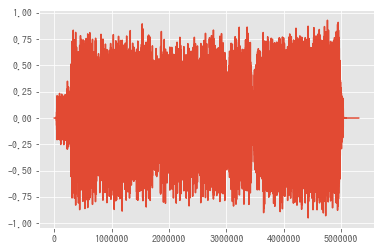

In [112]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(range(len(music)), music[:, 0])

- それを細かい時間（0.01-0.04秒程度、正確には512-2048サンプル）取り出す
- 以下は512サンプル

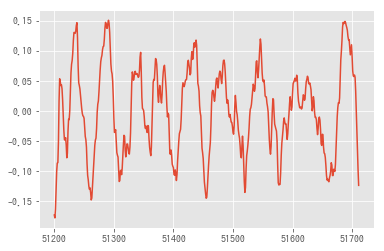

In [114]:
plt.plot(range(512*100, 512*101), music[512*100:512*101, 0])

- それをフーリエ変換にかけて周波数別の強度を算出します。

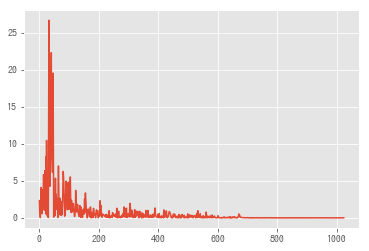

In [126]:
s = stft(music[512*100:512*101, 0])
plt.plot(abs(s[:, 0]))

In [124]:
s

array([[ 2.3326514 +0.0000000e+00j,  2.3291814 +0.0000000e+00j],
       [-0.8325999 +4.7921736e-17j, -1.4997118 -2.0562969e-03j],
       [-0.66875815-1.4197523e-16j,  0.6661692 +4.0751300e-03j],
       ...,
       [-0.00489231-4.6242272e-17j,  0.00482983-2.9490899e-05j],
       [-0.00790218-1.3769368e-16j, -0.01274073+1.4962900e-05j],
       [ 0.02061911+0.0000000e+00j,  0.02060434+0.0000000e+00j]],
      dtype=complex64)

- これを人間に聞こえるのと同じ尺度へと変更します。具体的には、周波数の情報がこれだと512個もあるので、80個ほどに減らしてデータ量を削減すると同時に、log10log10を取ります.

- この一連の作業を0.01秒ずつ（これも正確には512サンプル）ずらしながら曲全体に対して行います。

In [85]:
def Frame(data, nhop, nfft):
    
    length = data.shape[0]
    framedata = np.concatenate((data, np.zeros(nfft)))
    
    return np.array([framedata[i*nhop:i*nhop+nfft] for i in range(length//nhop)])

In [90]:
def fft_and_melscale(song, nhop=512, nffts=[1024, 2048, 4096], mel_nband=80, mel_freqlo=27.5, mel_freqhi=16000.0, include_zero_cross=False):

    feat_channels = []
    
    for nfft in nffts:
        feats = []
        window = signal.blackmanharris(nfft)
        filt = mel(samplerate, nfft, mel_nband, mel_freqlo, mel_freqhi)
        frame = Frame(song.data, nhop, nfft)
        print(frame.shape)
        processedframe = fft(window*frame)[:, :nfft//2+1]
        processedframe = np.dot(filt, np.transpose(np.abs(processedframe)**2))
        processedframe = 20*np.log10(processedframe+0.1)
        print(processedframe.shape)
        feat_channels.append(processedframe)

    if include_zero_cross:
        song.zero_crossing = np.where(np.diff(np.sign(song.data)))[0]
        print(song.zero_crossing)
    
    return np.array(feat_channels)

In [91]:
feats = fft_and_melscale((data[:,0]+data[:,1])/2)

(10371, 1024)
(80, 10371)
(10371, 2048)
(80, 10371)
(10371, 4096)
(80, 10371)


In [103]:
def multi_fft_and_melscale(songs, nhop=512, nffts=[1024, 2048, 4096], mel_nband=80, mel_freqlo=27.5, mel_freqhi=16000.0, include_zero_cross=False):
    for i in prange(len(songs)):
        songs[i].feats = fft_and_melscale(
            songs[i], nhop, nffts, mel_nband, mel_freqlo, mel_freqhi)